In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import math 
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from scipy import stats 
import plotly.express as px
from sklearn import preprocessing
from sklearn.linear_model import Lasso
import warnings

In [456]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')  

#Carga de datos

In [457]:
train_data_full = pd.read_csv('house_train_raw.csv')

#Dimension del Dataframe

In [458]:
train_data_full.shape

(1460, 81)

#Verifico la distribucion de la columna target 

In [459]:
train_data_full['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

#No sigue una distribucion Normal. Lo cual es logico, los precios no pueden tomar valores negativos . Los precios siguen una distribucion Lognormal

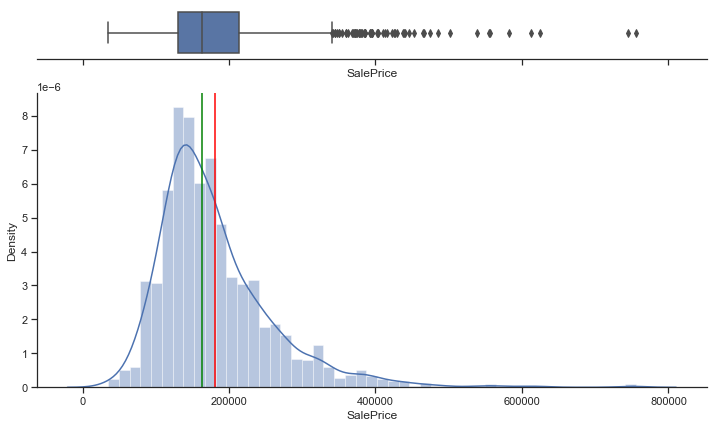

Skewness: 1.882876
Kurtosis: 6.536282


In [460]:
sns.set(style="ticks")
x = train_data_full['SalePrice']
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(12,7))

sns.boxplot(x, ax=ax_box)
sns.distplot(x, ax=ax_hist)
plt.axvline(x = x.mean(), c = 'red')
plt.axvline(x = x.median(), c = 'green')

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.show()
print("Skewness: %f" % train_data_full['SalePrice'].skew())
print("Kurtosis: %f" % train_data_full['SalePrice'].kurt())

#Aplico logaritmo para visualizar la distribucion como normal

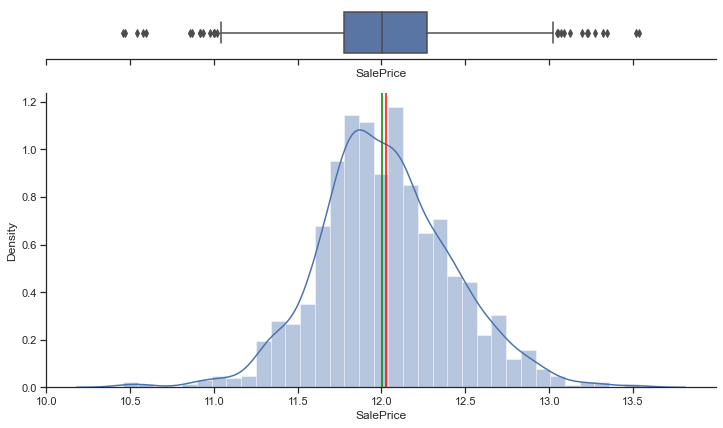

In [461]:
sns.set(style="ticks")

x = (np.log1p(train_data_full['SalePrice']))
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(12,7))

sns.boxplot(x, ax=ax_box)
sns.distplot(x, ax=ax_hist)
plt.axvline(x = x.mean(), c = 'red')
plt.axvline(x = x.median(), c = 'green')

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.show()

#Listado de columnas

In [462]:
train_data_full.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [463]:
#elimino filas con precio nulos
train_data_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
train_data_full['SalePrice_log']=np.log1p(train_data_full['SalePrice'])

#Fraccion de datos para realizar pruebas de validacion
train_data=train_data_full.sample(frac=0.95, random_state=786)

#Creo mi df con los features (sin columna target)
train_data_unseen=train_data_full.drop(train_data.index)
train_data = train_data_full.drop(['SalePrice'], axis=1)
train_data = train_data_full.drop(['SalePrice_log'], axis=1)
train_data = train_data_full.drop(['Id'], axis=1)


In [464]:
train_data_full = train_data_full.drop(['Id'], axis=1)

#Verificacion de datos faltantes

In [465]:
total = train_data.isnull().sum().sort_values(ascending=False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageQual,81,0.055479
GarageFinish,81,0.055479
GarageCond,81,0.055479


#Busco si hay columnas con datos faltantes

In [466]:
columns_with_null = train_data.count()[train_data.count()<0.80*max(train_data.count())].index.tolist()
print("columnas a eliminar: \n",columns_with_null)

columnas a eliminar: 
 ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [467]:
train_data.drop(columns_with_null, inplace= True, axis = 1)
train_data_full.drop(columns_with_null, inplace= True, axis = 1)

#Determino columnas categoricas

In [468]:
categorical_cols = {cname for cname in train_data.columns if train_data[cname].dtype == "object"}


#Determino columnas numericas

In [469]:
numerical_cols = {cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']}

In [470]:
print("columnas cuantitativas: " + str(len(categorical_cols)))
print("columnas cualitativas: " + str(len(numerical_cols)))

columnas cuantitativas: 38
columnas cualitativas: 38


In [471]:
train_data[numerical_cols].head(1)

,BsmtHalfBath,ScreenPorch,MiscVal,BsmtFullBath,PoolArea,SalePrice_log,OverallQual,TotRmsAbvGrd,GarageCars,LotFrontage,...,OverallCond,BedroomAbvGr,1stFlrSF,GarageYrBlt,BsmtUnfSF,LowQualFinSF,YearRemodAdd,MoSold,FullBath,HalfBath
0,0,0,0,1,0,12.247699,7,8,2,65.0,...,5,3,856,2003.0,150,0,2003,2,2,1


In [472]:
train_data[categorical_cols].head(1)

,SaleType,BsmtFinType1,HouseStyle,Street,KitchenQual,Neighborhood,BsmtQual,Functional,CentralAir,Exterior1st,...,GarageCond,LandSlope,GarageQual,BsmtCond,BldgType,ExterQual,Utilities,MasVnrType,SaleCondition,LandContour
0,WD,GLQ,2Story,Pave,Gd,CollgCr,Gd,Typ,Y,VinylSd,...,TA,Gtl,TA,TA,1Fam,Gd,AllPub,BrkFace,Normal,Lvl


#Verifico correlacion de las columnas

In [473]:
train_data_full.corr()['SalePrice'].sort_values(ascending=False).head(15)

SalePrice        1.000000
SalePrice_log    0.948374
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
Name: SalePrice, dtype: float64

#correlaciones mayor a 0.50

<AxesSubplot:>

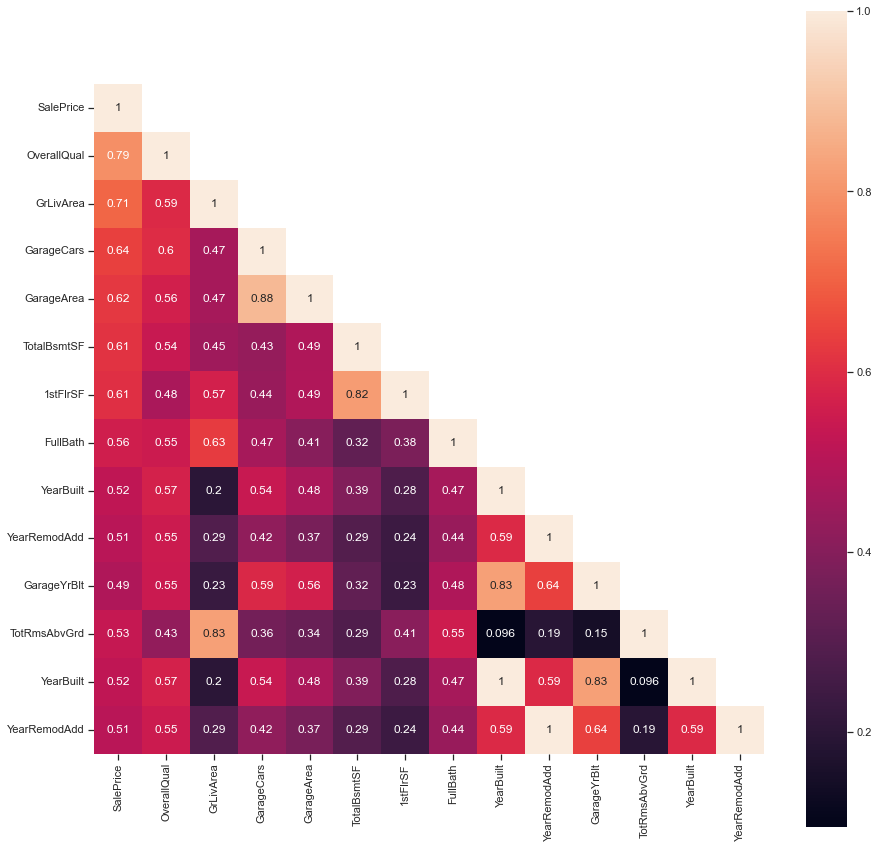

In [474]:
cor_mat= train_data_full[['SalePrice','OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','YearRemodAdd','GarageYrBlt','TotRmsAbvGrd', 'YearBuilt','YearRemodAdd']].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(15,15)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

#Visualizo graficamente

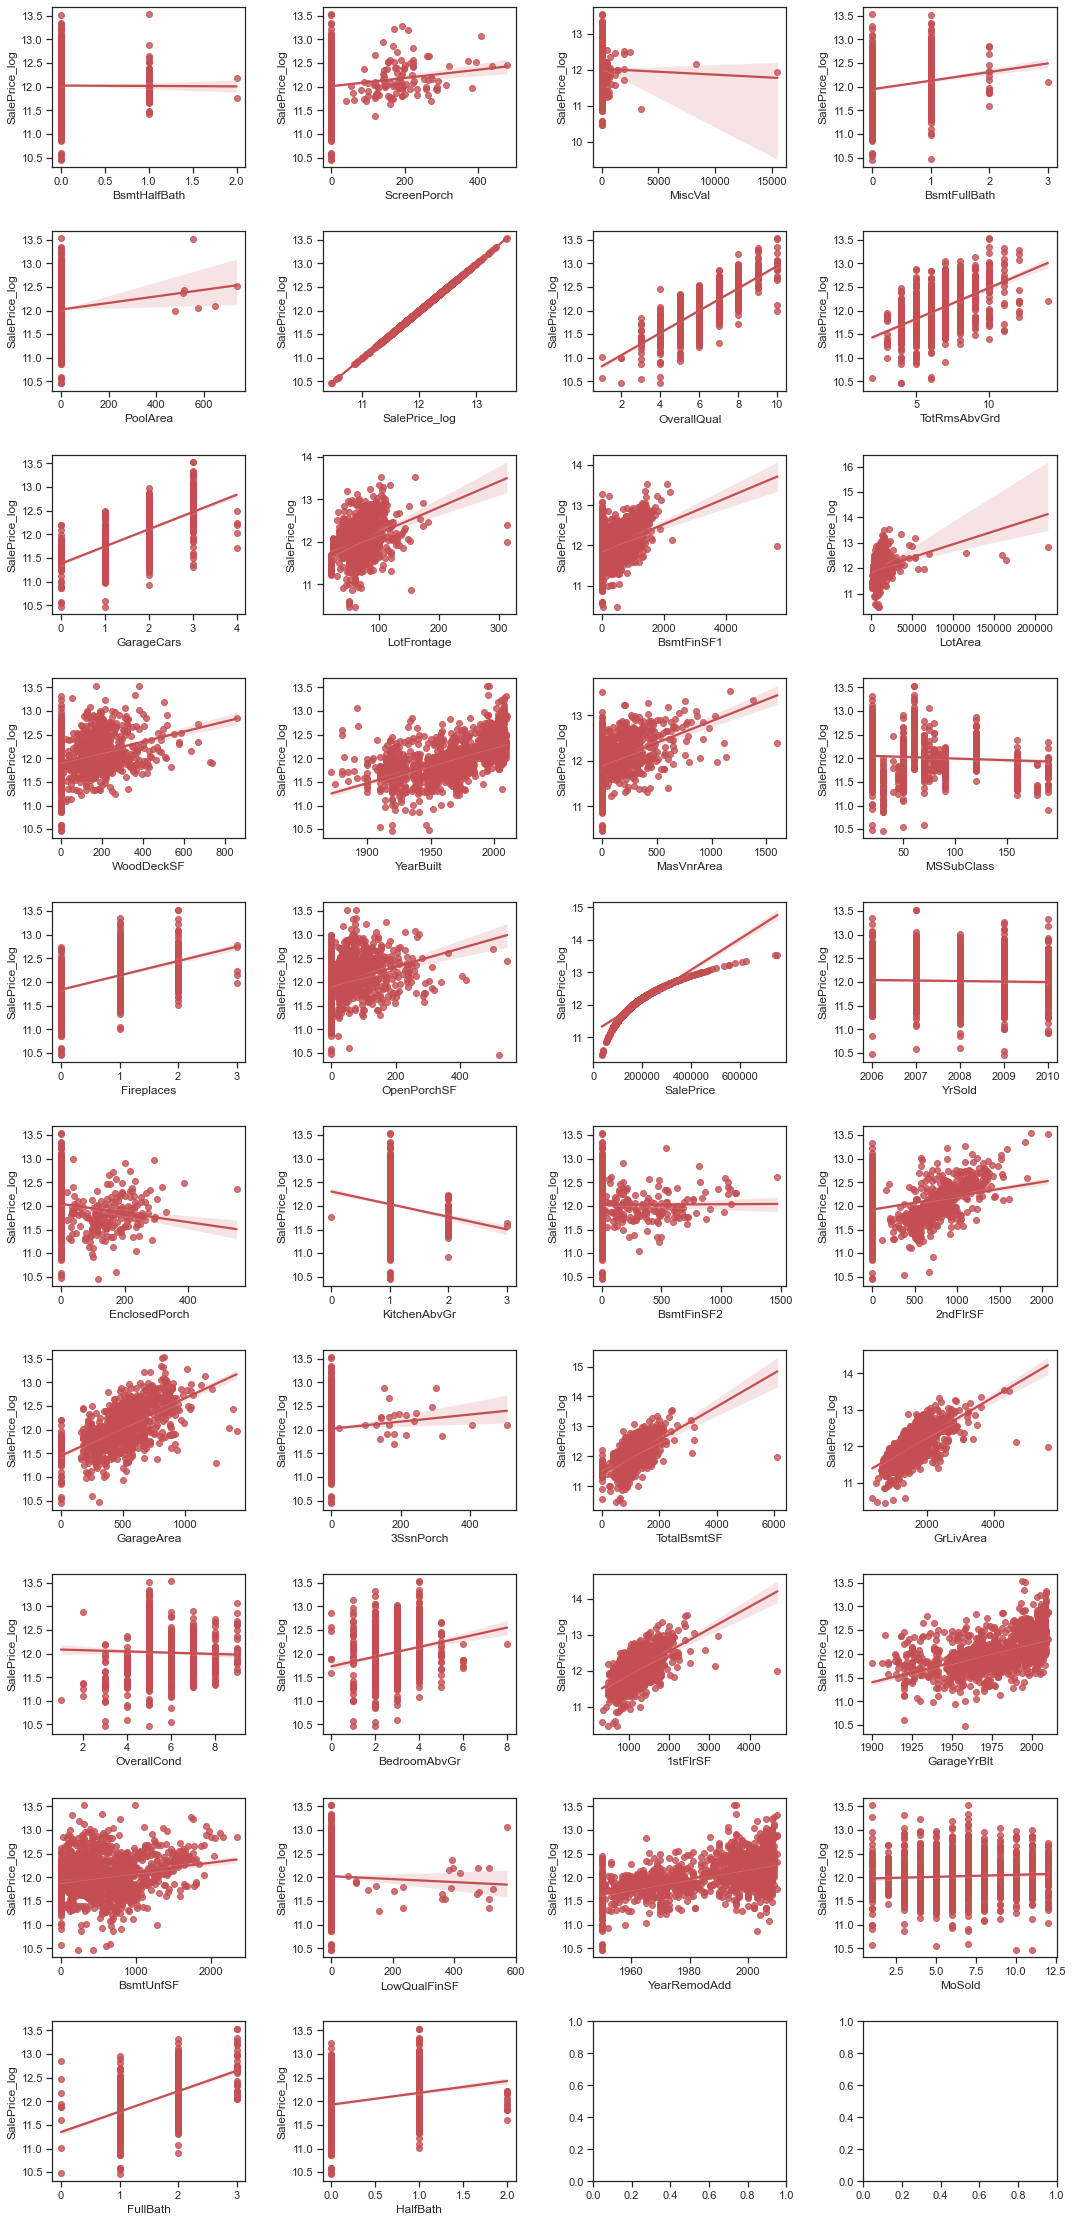

In [475]:
n=len(train_data[numerical_cols].columns) # number of plots
f, axes = plt.subplots(nrows=(n-1)//4 +1,ncols=4,squeeze=False,figsize=(18,4*((n-1)//4 +1))) # represent them on 4 columnms
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4) # increase space between plots

for col, ax in zip(numerical_cols, axes.flatten()[:n]):
    sns.regplot(data=train_data,x=col,y='SalePrice_log', ax=ax ,color='r')

plt.show()

#columnas con una relacion debil parecen ser: 'MSSubClass', 'LotArea', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
'BedroomAbvGr', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'

In [476]:
min_val_corr = 0.5  
corr = train_data_full.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_cols)
ser_corr = corr_abs.nlargest(nr_num_cols, 'SalePrice_log')['SalePrice_log']

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

In [477]:
print("Listado de columnas con correlacion alta:")
print(cols_abv_corr_limit)

Listado de columnas con correlacion alta:
['SalePrice_log', 'SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'TotRmsAbvGrd']


In [478]:
print("Listado de columnas con correlacion baja :")
print(cols_bel_corr_limit)

Listado de columnas con correlacion baja :
['Fireplaces', 'MasVnrArea', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', 'OpenPorchSF', '2ndFlrSF', 'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'EnclosedPorch', 'KitchenAbvGr', 'ScreenPorch', 'MSSubClass', 'PoolArea', 'MoSold', '3SsnPorch', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2']


#Analisis de las columnas con las que mayor correlacion hay: 

#OverallQual: Calificacion del material y acabado de la casa

In [479]:
fig = px.box(train_data_full, x="OverallQual", y="SalePrice")
fig.show()

#TotalBsmtSF: Tamaño del sotano

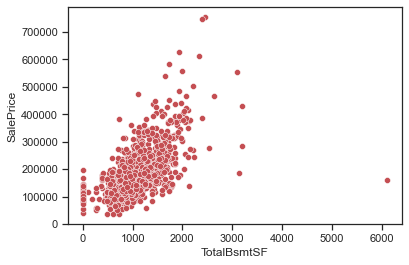

In [480]:
ax = sns.scatterplot(x="TotalBsmtSF", y="SalePrice", data=train_data_full, color='r')

#1stFlrSF: Pies cuadrados del primer piso

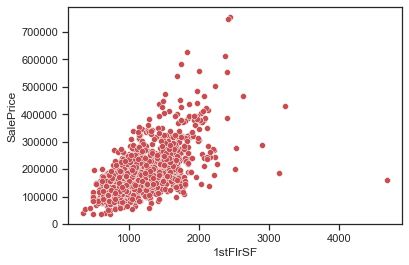

In [481]:
ax = sns.scatterplot(x="1stFlrSF", y="SalePrice", data=train_data_full, color='r')

#GrLivArea: Pies cuadrados del area principal


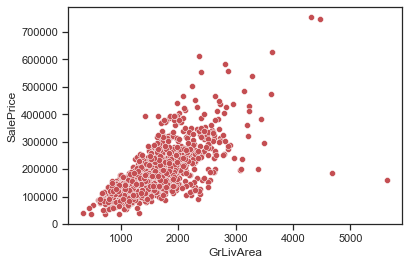

In [482]:
ax = sns.scatterplot(x="GrLivArea", y="SalePrice", data=train_data_full, color='r')

#GarageCars: Cantidad de autos que permite alojar el garage

In [483]:
fig = px.box(train_data_full, x="GarageCars", y="SalePrice")
fig.show()

#GarageArea: tamaño del garage

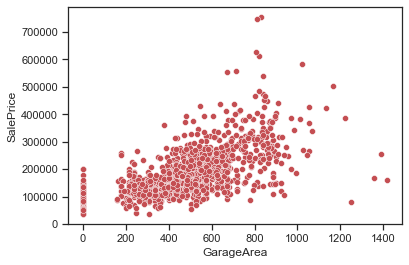

In [484]:
ax = sns.scatterplot(x="GarageArea", y="SalePrice", data=train_data_full, color='r')

#Se eliminan Outliers:

In [485]:
train_data = train_data.drop(train_data[(train_data['SalePrice']>740000)].index).reset_index(drop=True)

In [486]:
train_data = train_data.drop(train_data[(train_data['1stFlrSF']>3500)].index).reset_index(drop=True)

In [487]:
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4500)].index).reset_index(drop=True)

In [488]:
train_data = train_data.drop(train_data[(train_data['GarageCars']>3)].index).reset_index(drop=True)

In [489]:
train_data = train_data.drop(train_data[(train_data['GarageArea']>1240)].index).reset_index(drop=True)

#Relacion entre Precio y columnas categoricas

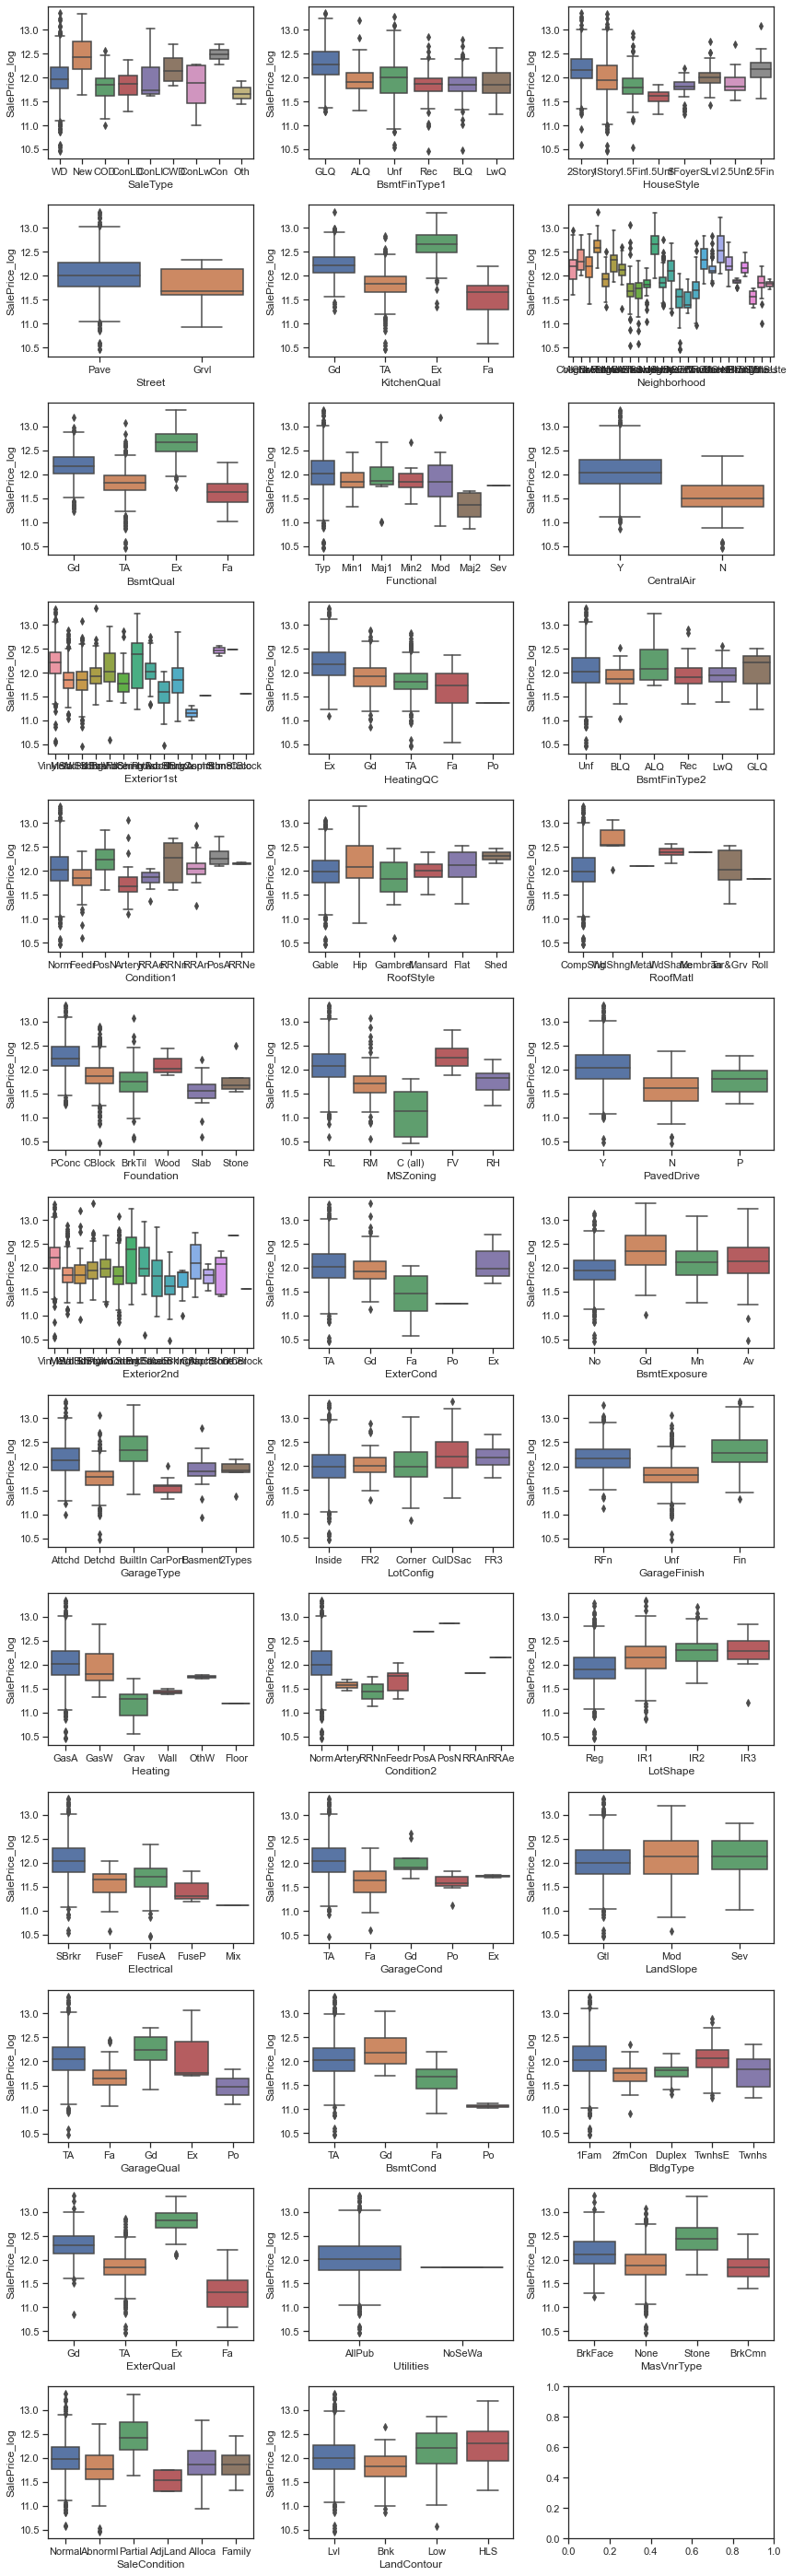

In [490]:
li_cat_feats = list(categorical_cols)
nr_rows = 13
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y='SalePrice_log', data=train_data, ax = axs[r][c])
    
plt.tight_layout()    
plt.show()   

In [491]:
cat_fuerte = [ 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 
                     'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

cat_Debil = ['Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 
                  'SaleCondition' ]

#Elimino columnas: categoricas y numericas con debil o negativa relacion

In [492]:
train_data.drop(cols_bel_corr_limit, inplace= True, axis = 1)
train_data.drop(cat_Debil, inplace= True, axis = 1)


#Codifico variables categoricas con buena correlacion

In [493]:
def codificar_cat(data,cat_cols):
    label_encoder=preprocessing.LabelEncoder()
    for column in data:
        if column in cat_cols:
            data[column] =label_encoder.fit_transform (data[column])
    return data

In [494]:
train_data=codificar_cat(train_data,cat_fuerte)

In [497]:
train_data.head(2)

,MSZoning,Neighborhood,Condition2,OverallQual,YearBuilt,YearRemodAdd,MasVnrType,ExterQual,BsmtQual,TotalBsmtSF,...,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,SaleType,SalePrice,SalePrice_log
0,3,5,2,7,2003,2003,1,2,2,856,...,1710,2,2,8,2003.0,2,548,8,208500,12.247699
1,3,24,2,6,1976,1976,2,3,2,1262,...,1262,2,3,6,1976.0,2,460,8,181500,12.109016


#Verifico correlacion de variables categoricas con Precio

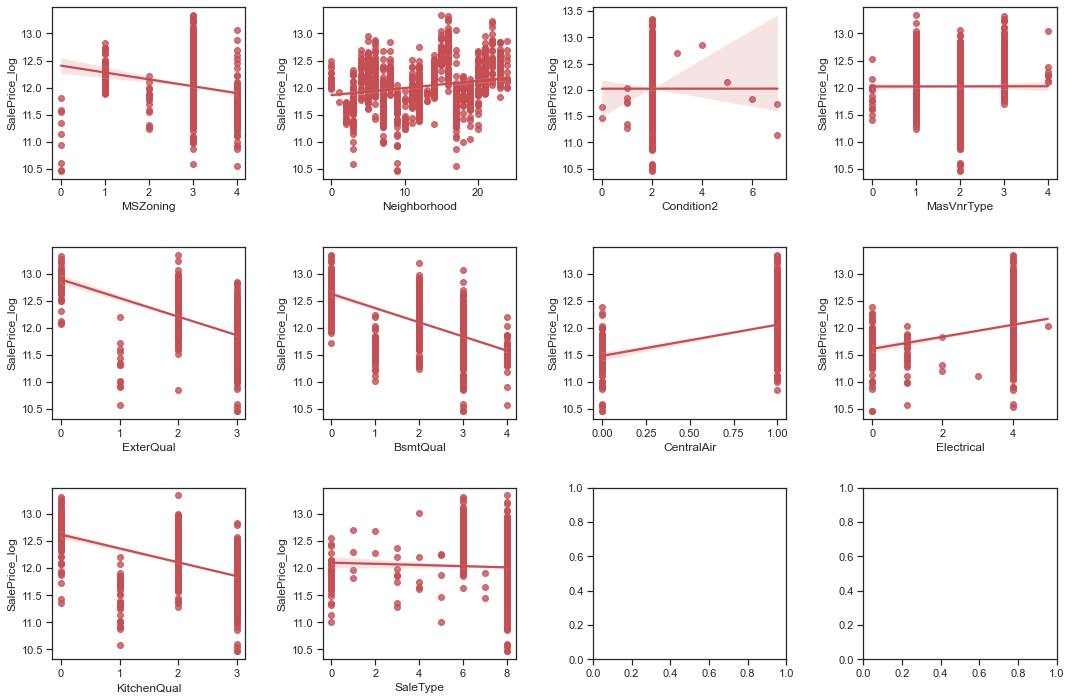

In [498]:
n=len(train_data[cat_fuerte].columns) # number of plots
f, axes = plt.subplots(nrows=(n-1)//4 +1,ncols=4,squeeze=False,figsize=(18,4*((n-1)//4 +1))) # represent them on 4 columnms
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4) # increase space between plots

for col, ax in zip(cat_fuerte, axes.flatten()[:n]):
    sns.regplot(data=train_data,x=col,y='SalePrice_log', ax=ax ,color='r')

plt.show()

In [499]:
corr1 = train_data.corr()
corr_abs_1 = corr1.abs()

nr_all_cols = len(train_data)
ser_corr_1 = corr_abs_1.nlargest(nr_all_cols, 'SalePrice_log')['SalePrice_log']

print(ser_corr_1)
cols_bel_corr_limit_1 = list(ser_corr_1[ser_corr_1.values <= min_val_corr].index)



SalePrice_log    1.000000
SalePrice        0.954570
OverallQual      0.819771
GrLivArea        0.718761
GarageCars       0.692023
GarageArea       0.669486
TotalBsmtSF      0.641420
1stFlrSF         0.613357
YearBuilt        0.592796
FullBath         0.591469
BsmtQual         0.589707
ExterQual        0.589443
YearRemodAdd     0.567623
GarageYrBlt      0.546999
TotRmsAbvGrd     0.533766
KitchenQual      0.530558
CentralAir       0.359555
Electrical       0.296225
MSZoning         0.200649
Neighborhood     0.200404
SaleType         0.042139
MasVnrType       0.001822
Condition2       0.000123
Name: SalePrice_log, dtype: float64


#Elimino columnas categoricas con baja correlacion

In [500]:
catg_drop = ['Neighborhood' , 'Condition2', 'MasVnrType', 'Electrical', 'SaleType','MSZoning']

In [501]:
train_data.drop(catg_drop, inplace= True, axis = 1)


In [502]:
train_data.columns

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'BsmtQual',
       'TotalBsmtSF', 'CentralAir', '1stFlrSF', 'GrLivArea', 'FullBath',
       'KitchenQual', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'SalePrice', 'SalePrice_log'],
      dtype='object')

#Mapa de correlacion 

<AxesSubplot:>

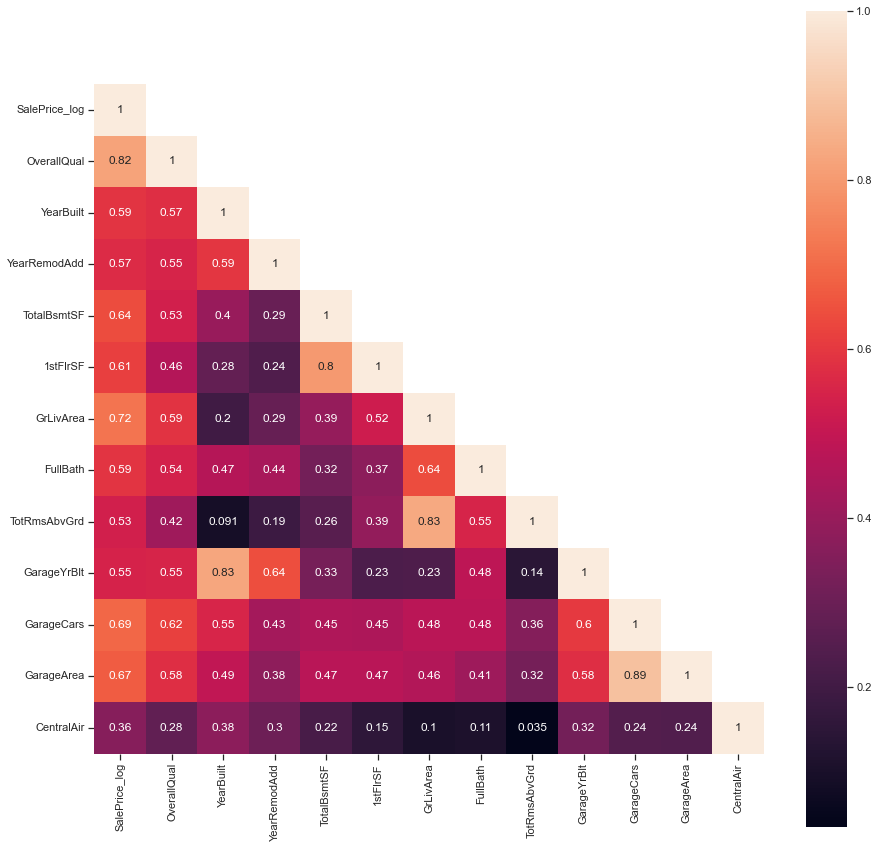

In [537]:
cor_mat= train_data[['SalePrice_log','OverallQual', 'YearBuilt', 'YearRemodAdd', 
       'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath',
       'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'CentralAir']].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(15,15)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [504]:
train_data

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,TotalBsmtSF,CentralAir,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,SalePrice,SalePrice_log
0,7,2003,2003,2,2,856,1,856,1710,2,2,8,2003.0,2,548,208500,12.247699
1,6,1976,1976,3,2,1262,1,1262,1262,2,3,6,1976.0,2,460,181500,12.109016
2,7,2001,2002,2,2,920,1,920,1786,2,2,6,2001.0,2,608,223500,12.317171
3,7,1915,1970,3,3,756,1,961,1717,1,2,7,1998.0,3,642,140000,11.849405
4,8,2000,2000,2,2,1145,1,1145,2198,2,2,9,2000.0,3,836,250000,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,6,1999,2000,3,2,953,1,953,1647,2,3,7,1999.0,2,460,175000,12.072547
1445,6,1978,1988,3,2,1542,1,2073,2073,2,3,7,1978.0,2,500,210000,12.254868
1446,7,1941,2006,0,3,1152,1,1188,2340,2,2,9,1941.0,1,252,266500,12.493133
1447,5,1950,1996,3,3,1078,1,1078,1078,1,2,5,1950.0,1,240,142125,11.864469


##COLUMNAS A UTILIZAR

In [505]:
my_cols = ['OverallQual', 'YearRemodAdd', 'YearBuilt',
       'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath','TotRmsAbvGrd', 'GarageYrBlt',
        'GarageCars', 'GarageArea', 'KitchenQual','ExterQual','BsmtQual','CentralAir']



In [506]:
def RMSLE_score_model(data,model):

    #defino columna target
    y=data['SalePrice_log']
    
    transformer = SimpleImputer(strategy='most_frequent')
    #Si hubiera nulos imputo sus valores con la moda
    X=transformer.fit_transform(data[my_cols])
    
    #defino mis datos de entrenamiento y de validacion
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)
    
    #Entreno el modelo
    model.fit(X_train, y_train)

    #Calculo predicion con mis datos de validacion
    preds = model.predict(X_valid)
    
    #Devuelvo el error
    return mean_squared_log_error(y_valid, preds, squared=False)

In [507]:
def RMSLE_CV_score_model(data,model):

    #defino columna target
    y=data['SalePrice_log']
    
    transformer = SimpleImputer(strategy='most_frequent')
    #Si hubiera nulos imputo sus valores con la moda
    X=transformer.fit_transform(data[my_cols])
    
    scores = -1 * cross_val_score(model, X, y,
                              cv=5,
                              scoring='neg_mean_squared_log_error')
    #Devuelvo el error
    scores=np.sqrt(scores)
    return scores.mean()

#Linear regression with cross validation - all features

In [508]:
model = LinearRegression()
RMSLE = RMSLE_CV_score_model(train_data,model)
print('RMSLE ='+ str(RMSLE))

RMSLE =0.011354359885684392


In [509]:
#RegresionLineal
RL=RMSLE_CV_score_model(train_data,model)

#Random Forest

In [510]:
for n_estimators in [50,100,500,1000,2000]:
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=5, min_samples_split=4)
    RMSLE = RMSLE_CV_score_model(train_data,model)
    print('RMSLE = %.10f for n_estimators = %d'%(RMSLE, n_estimators))
    

RMSLE = 0.0119477793 for n_estimators = 50
RMSLE = 0.0119743669 for n_estimators = 100
RMSLE = 0.0118897357 for n_estimators = 500
RMSLE = 0.0118768320 for n_estimators = 1000
RMSLE = 0.0118712257 for n_estimators = 2000


In [511]:
#Mejor Random Forest
model = RandomForestRegressor(n_estimators=500, random_state=5, min_samples_split=4)
RF = RMSLE_CV_score_model(train_data,model)

#Lasso

In [512]:
for alpha in [0,0.002,0.1,0.2,0.5,0.8,1]:
    model = Lasso(random_state=0, alpha=alpha, max_iter=10000, normalize=False)
    MAE = RMSLE_CV_score_model(train_data,model)
    print('RMSLE = %.10f for alpha = %f '%(MAE, alpha))

RMSLE = 0.0113543599 for alpha = 0.000000 
RMSLE = 0.0113678617 for alpha = 0.002000 
RMSLE = 0.0129161235 for alpha = 0.100000 
RMSLE = 0.0130142396 for alpha = 0.200000 
RMSLE = 0.0131734333 for alpha = 0.500000 
RMSLE = 0.0134205348 for alpha = 0.800000 
RMSLE = 0.0136444234 for alpha = 1.000000 


In [513]:
#Mejor Lasso
model = Lasso(random_state=0, alpha=0.0, max_iter=1000, normalize=False)
las = RMSLE_CV_score_model(train_data,model)

#KNN Regressor

In [514]:

for n_neighbors in [3,4,5,6,7,10,15]:
    model = KNeighborsRegressor(n_neighbors=n_neighbors) 
    RMSLE = RMSLE_CV_score_model(train_data,model)
    print('RMSLE = %.10f for n_neighbors = %d '%(RMSLE, n_neighbors))

RMSLE = 0.0157894193 for n_neighbors = 3 
RMSLE = 0.0154433875 for n_neighbors = 4 
RMSLE = 0.0154088321 for n_neighbors = 5 
RMSLE = 0.0153655052 for n_neighbors = 6 
RMSLE = 0.0153571288 for n_neighbors = 7 
RMSLE = 0.0153335064 for n_neighbors = 10 
RMSLE = 0.0154670703 for n_neighbors = 15 


In [515]:
#Mejor KNNR
model = KNeighborsRegressor(n_neighbors=3) 
KNNR = RMSLE_CV_score_model(train_data,model)

#XGBOOST

In [ ]:
for n_estimators in [700,900,3400,3500,4000,5000]:
    model = XGBRegressor(learning_rate=0.01,n_estimators=n_estimators,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006) 
    RMSLE = RMSLE_CV_score_model(train_data,model)
    print('RMSLE = %.10f for n_estimators = %d '%(RMSLE, n_estimators))

In [ ]:
#Mejor XGBRegressor
model = XGBRegressor(learning_rate=0.01,n_estimators=900,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006) 
XGB = RMSLE_CV_score_model(train_data,model)

In [532]:
XGB

0.01129120870407297

#Gradient boost

In [518]:
for n_estimators in [10,72,120,550,1000,3000]:
    learning_rate = 0.2
    model = GradientBoostingRegressor(random_state=0, n_estimators=n_estimators, learning_rate=learning_rate,max_depth=3) 
    RMSLE = RMSLE_CV_score_model(train_data,model)
    print('RMSLE = %.10f for n_estimators = %d and learning_rate = %f'%(RMSLE, n_estimators, learning_rate))

RMSLE = 0.0131496357 for n_estimators = 10 and learning_rate = 0.200000
RMSLE = 0.0114290872 for n_estimators = 72 and learning_rate = 0.200000
RMSLE = 0.0115492228 for n_estimators = 120 and learning_rate = 0.200000
RMSLE = 0.0124285839 for n_estimators = 550 and learning_rate = 0.200000
RMSLE = 0.0126253921 for n_estimators = 1000 and learning_rate = 0.200000
RMSLE = 0.0127554135 for n_estimators = 3000 and learning_rate = 0.200000


In [519]:
#Mejor Gradient Boost
learning_rate = 0.2
model = GradientBoostingRegressor(random_state=0, n_estimators=70, learning_rate=learning_rate, max_depth=3) 
GB = RMSLE_CV_score_model(train_data,model)


#RIDGE

In [520]:
for alpha in [0.001,0.005,0.01,0.1,0.5,1]:
    model = Ridge( alpha=alpha,random_state=0,normalize=False) 
    RMSLE = RMSLE_CV_score_model(train_data,model)
    print('RMSLE = %.10f for alpha = %f '%(RMSLE, alpha))

RMSLE = 0.0113543592 for alpha = 0.001000 
RMSLE = 0.0113543564 for alpha = 0.005000 
RMSLE = 0.0113543530 for alpha = 0.010000 
RMSLE = 0.0113542920 for alpha = 0.100000 
RMSLE = 0.0113540457 for alpha = 0.500000 
RMSLE = 0.0113537925 for alpha = 1.000000 


In [521]:
#Mejor Ridge
modelRidge = Ridge( alpha=0.001,random_state=0,normalize=False) 
Ridg= RMSLE_CV_score_model(train_data,modelRidge)


#Elastic Net

In [522]:
for alpha in [0.001,0.005,0.01,0.1,0.5,1]:
    model = ElasticNet( alpha=alpha,random_state=0, max_iter=10000, tol=1e-04,l1_ratio=0.04) 
    MAE = RMSLE_CV_score_model(train_data,model)
    print('RMSLE = %.10f for alpha = %f '%(MAE, alpha))

RMSLE = 0.0113533696 for alpha = 0.001000 
RMSLE = 0.0113536687 for alpha = 0.005000 
RMSLE = 0.0113615042 for alpha = 0.010000 
RMSLE = 0.0116053519 for alpha = 0.100000 
RMSLE = 0.0121617780 for alpha = 0.500000 
RMSLE = 0.0126057084 for alpha = 1.000000 


In [523]:
#Mejor ElasticNet
model = ElasticNet( alpha=0.001000,random_state=0, max_iter=10000, tol=1e-04,l1_ratio=0.04) 
Elas = RMSLE_CV_score_model(train_data,model)
 

#Decision Tree

In [524]:
for max_Depht in [4,5,7,8,9,10,15,20]:
    model = DecisionTreeRegressor(max_depth=max_Depht, random_state=0, max_features=8)
    RMSLE = RMSLE_CV_score_model(train_data,model)
    print('RMSLE = %.10f for depht = %d'%(RMSLE, max_Depht))
    

RMSLE = 0.0177343836 for depht = 4
RMSLE = 0.0163242722 for depht = 5
RMSLE = 0.0154495477 for depht = 7
RMSLE = 0.0162549939 for depht = 8
RMSLE = 0.0166003778 for depht = 9
RMSLE = 0.0164567269 for depht = 10
RMSLE = 0.0165732169 for depht = 15
RMSLE = 0.0177128686 for depht = 20


In [525]:
#Mejor DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=5, random_state=5, max_features=10)
DTR= RMSLE_CV_score_model(train_data,model)


#Comparo los resultados de los diferentes modelos

In [526]:
scores = [RL, RF, las, XGB, GB, Ridg, Elas, DTR]
modelos = ['Linear', 'RForest', 'Lasso', 'XGBOOST', 'GradientBoost', 'RIDGE', 'ElasticNet','DecisionTree']
metricas = {'modelos':modelos, 'scores':scores}
df_metricas = pd.DataFrame(metricas)

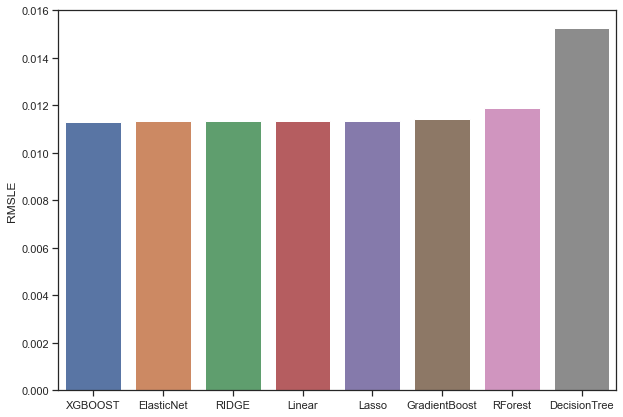

In [527]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=modelos, y=scores,data=df_metricas ,ax=ax, order=df_metricas.sort_values('scores').modelos)
plt.ylabel('RMSLE')
plt.show()

#Mejor Score XGBOOST

In [528]:
print('score: ' + str(XGB))

score: 0.01129120870407297


#REALIZO VALIDACION CON DATOS SEPARADOS

#Con el modelo elegido calculo prediccion y exporto a CSV

In [529]:
def model_to_csv(data,model,predecir):
    #defino features
    X=data[my_cols]
    #defino columna target
    y=np.log1p(data['SalePrice'])
    #Busco columnas categoricas para codificarlas ya que los modelos no aceptan variables no numericas
    cat_cols = {cname for cname in X.columns if X[cname].dtype == "object"}
    X=codificar_cat(X,cat_cols)
    
    #A los valores nulos si los hubiera los completa con la moda
    transformer = SimpleImputer(strategy='most_frequent')
    
    X=transformer.fit_transform(X)

    #Entreno modelo
    model.fit(X, y)
    #Calulo mis precios predecidos
    cat_colspred = {cname for cname in predecir.columns if predecir[cname].dtype == "object"}
    predecir=codificar_cat(predecir,cat_colspred)
    x_pred=predecir[my_cols]
    preds = model.predict(x_pred)
    #Como mi target era logaritmica . hago el paso inverso
    preds= np.exp(preds) 

    df_pred=pd.DataFrame(preds)
    df_pred.to_csv('pred_test.csv')

In [530]:
test = pd.read_csv('houses_test_raw.csv')

In [531]:
modelXGB = XGBRegressor(learning_rate=0.01,n_estimators=900,
                                     max_depth=5, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006) 
model_to_csv(train_data,modelXGB,test)

[19:47:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
